In [1]:
from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# Define data paths and classes
PATH = '/home/ubuntu/Repos/Data/PIM_Dataset/'
TRAIN_PATH = PATH + '/train'
TEST_PATH = PATH + 'val'
classes = ('good','bad')

SAMPLE_PATH = '/home/ubuntu/Repos/Data/PIM_Dataset/test/chared144_1.bmp'

In [3]:
!pwd
!ls /home/ubuntu/Repos/Data/PIM_Dataset/train
# chared144_1.bmp: PC bitmap, Windows 98/2000 and newer format, 514 x 429 x 24

/home/ubuntu/Repos/udemy_tut/resnet_hack
bad  good


'Windows Bitmap'

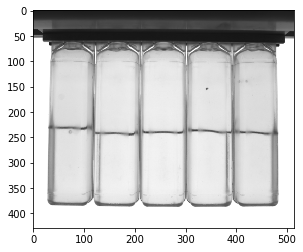

In [4]:
%matplotlib inline
pil_im = Image.open(SAMPLE_PATH, 'r')
plt.imshow(np.asarray(pil_im))
pil_im.format_description

In [5]:
im_arr = np.array(pil_im)
print(im_arr.shape)
print(pil_im)

(429, 514, 3)
<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=514x429 at 0x7F5094B75290>


In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]);

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
input_tensor = preprocess(pil_im)
input_batch = input_tensor.unsqueeze(0)
print(pil_im)
print(input_batch.shape)

<PIL.BmpImagePlugin.BmpImageFile image mode=RGB size=514x429 at 0x7F5094B75290>
torch.Size([1, 3, 224, 224])


In [8]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False, num_classes=2)
model.eval();

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


In [9]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with torch.no_grad():
    output = model(input_batch)
print(output[0])
print(torch.nn.functional.softmax(output[0], dim=0));



tensor([0.4177, 1.7967], device='cuda:0')
tensor([0.2012, 0.7988], device='cuda:0')


In [10]:

image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


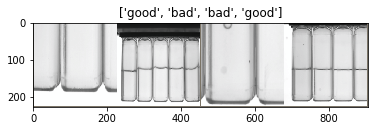

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [12]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    #print("TP: %.4f, FP: %.4f, TN: %.4f, FN: %.4f" % (TP, FP, TN, FN))
    return torch.Tensor([TP, FP, TN, FN])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            measures = torch.zeros(4)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                measures = measures + perf_measure(labels.data, preds)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            TP,FP,TN,FN = measures[0], measures[1], measures[2], measures[3]
            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
            # Specificity or true negative rate
            TNR = TN/(TN+FP)
            # Precision or positive predictive value
            PPV = TP/(TP+FP)
            # Negative predictive value
            NPV = TN/(TN+FN)
            # Fall out or false positive rate
            FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
            # False discovery rate
            FDR = FP/(TP+FP)

            # F1 Score
            F1 = 2 * (TPR * PPV) / (TPR + PPV)

            # Overall accuracy
            ACC = (TP+TN)/(TP+FP+FN+TN)
            print('phase:',phase)
            #print("TPR: %.4f, TNR: %.4f, PPV: %.4f, NPV: %.4f, FPR: %.4f, FNR: %.4f, FDR: %.4f, ACC: %.4f"
            #      % (TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC))
            print("ACC: %.4f, PPV: %.4f, TPR: %.4f, TNR: %.4f, F1: %.4f,"
                 % (ACC, PPV, TPR, TNR, F1))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # relevant:
            # conf matrix plot
            # ACC, PPV, TPR, TNR, F1
            # acc
            # precision
            # recall
            # f1  score
            # speific

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [15]:
from torchvision import datasets, models, transforms

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
phase: train
ACC: 0.7143, PPV: 0.7500, TPR: 0.8684, TNR: 0.3889, F1: 0.8049,
train Loss: 0.6522 Acc: 0.7143
phase: val
ACC: 0.6981, PPV: 0.6981, TPR: 1.0000, TNR: 0.0000, F1: 0.8222,
val Loss: 0.6618 Acc: 0.6981
Epoch 1/99
----------
phase: train
ACC: 0.7202, PPV: 0.7769, TPR: 0.8246, TNR: 0.5000, F1: 0.8000,
train Loss: 0.5741 Acc: 0.7202
phase: val
ACC: 0.9057, PPV: 0.8810, TPR: 1.0000, TNR: 0.6875, F1: 0.9367,
val Loss: 0.1997 Acc: 0.9057
Epoch 2/99
----------
phase: train
ACC: 0.7500, PPV: 0.7951, TPR: 0.8509, TNR: 0.5370, F1: 0.8220,
train Loss: 0.7408 Acc: 0.7500
phase: val
ACC: 0.6981, PPV: 0.6981, TPR: 1.0000, TNR: 0.0000, F1: 0.8222,
val Loss: 0.8846 Acc: 0.6981
Epoch 3/99
----------
phase: train
ACC: 0.7619, PPV: 0.8136, TPR: 0.8421, TNR: 0.5926, F1: 0.8276,
train Loss: 0.5868 Acc: 0.7619
phase: val
ACC: 0.7547, PPV: 1.0000, TPR: 0.6486, TNR: 1.0000, F1: 0.7869,
val Loss: 0.5110 Acc: 0.7547
Epoch 4/99
----------
phase: train
ACC: 0.8333, PPV: 0.8525, TPR

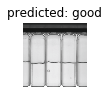

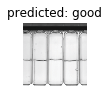

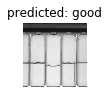

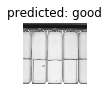

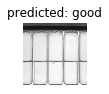

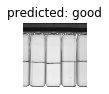

In [17]:
visualize_model(model_ft)

